## Step 0: Install packages and load data

In [ ]:
%pip install git+https://github.com/openai/CLIP.git
%pip install numpy pandas scikit-learn
#%pip install torch torchvision clip-by-openai numpy pandas scikit-learn

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-k51idfms
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-k51idfms
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import clip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from wordcloud import WordCloud
import spacy
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load datasets
fpath = "/content/drive/MyDrive/Task 2 NLP Dataset/"  # Adjust paths
train_path = fpath + "train/train.csv"
val_path = fpath + "val/val.csv"
test_path = fpath + "test/test.csv"
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [ ]:
print(train_df.head())
print(test_df.head())

for split, df in zip(["Train", "Validation", "Test"], [train_df, val_df, test_df]):
    print(f"{split} Label Distribution:")
    print(df['label'].value_counts())

for split_name, df in zip(["Train", "Validation", "Test"], [train_df, val_df, test_df]):
    plt.figure(figsize=(4,3))
    sns.countplot(x='label', data=df)
    plt.title(f'{split_name} Set Label Distribution')
    plt.show()

# Violin Plot
sentence_lengths = []
for split_name, df in zip(["Train", "Validation", "Test"], [train_df, val_df, test_df]):
    for sentence in df['sentence']:
        sentence_lengths.append({
            'Split': split_name,
            'Length': len(sentence.split())
        })
sentence_df = pd.DataFrame(sentence_lengths)

plt.figure(figsize=(10, 6))
sns.violinplot(x="Split", y="Length", data=sentence_df, palette="Pastel1", inner="quartile")
plt.title("Sentence Length Distribution Across Splits", fontsize=14, weight='bold')
plt.xlabel("Dataset Split", fontsize=12)
plt.ylabel("Sentence Length in Word Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", palette="pastel")
ax = sns.boxplot(
    x=train_df['sentence'].apply(lambda x: len(x.split())),
    color="#7FB3D5",
    width=0.4,
    fliersize=5,
    linewidth=1.5,
)
plt.title("Distribution of Sentence Lengths in Training Set", fontsize=16, weight='bold')
plt.xlabel("Number of Words in Sentence)", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks([])
sns.despine(left=True, bottom=False)

for line in ax.lines:
    line.set_color('#1F618D')
plt.tight_layout()
plt.show()


# Histogram
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(
    train_df['image_caption'].apply(lambda x: len(x.split())),
    bins=20,
    kde=True,
    color="#48C9B0",
    edgecolor='black',
    linewidth=1.2
)

plt.title("Image Caption Length Distribution of Train Set", fontsize=16, weight='bold')
plt.xlabel("Number of Words in Caption)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# BarPlot
sns.set(style="whitegrid")
top_compounds = train_df['compound'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_compounds.index, y=top_compounds.values, palette="viridis")
plt.title("Top 10 Most Frequent Compounds in Train Set", fontsize=16, weight='bold')
plt.xlabel("Compound", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()




def visualise_data(df, image_folder):
    fig, axes = plt.subplots(len(df)//6+1, 6, figsize=(18, 10))
    axes = axes.flatten()
    for idx, row in df.iterrows():
        img_path = os.path.join(image_folder, row['image_name'])
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"Compound: {row['compound']}\nLabel: {row['label']}", fontsize=10)
            axes[idx].axis('off')
        except:
            continue
    plt.tight_layout()
    plt.show()

visualise_data(test_df, fpath + "test/images")

text_corpus = " ".join(train_df['sentence'])
wordcloud = WordCloud(width=800, height=400).generate(text_corpus)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

compound_text = " ".join(train_df['compound'])
compound_wordcloud = WordCloud(width=800, height=400).generate(compound_text)
plt.figure(figsize=(15, 7))
plt.imshow(compound_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Compound Idioms")
plt.show()


# Display the images
img_shapes = []

for img_name in tqdm(train_df['image_name'].sample(50)):
    img_path = os.path.join(fpath + "train/images", img_name)
    try:
        with Image.open(img_path) as img:
            img_shapes.append(img.size)
    except Exception as e:
        print(f"Skipping {img_name}: {e}")

widths, heights = zip(*img_shapes)

plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.7, color='steelblue', edgecolor='k')
plt.xlabel("Width", fontsize=12)
plt.ylabel("Height", fontsize=12)
plt.title("Scatter Plot of Image Dimensions", fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Step 1: NLP Exploratory Data Analysis (Note: only need to process the text data). Write down your code below.

In [ ]:
nlp = spacy.load("en_core_web_sm")
for sent in train_df['sentence'].sample(3):
    doc = nlp(sent)
    print(f"Sentence: {sent}")
    print([(token.text, token.pos_, token.dep_) for token in doc])

Sentence: Even the somewhat seedy failed private eye has a heart of gold (and a bad hairstyle).
[('Even', 'ADV', 'advmod'), ('the', 'DET', 'det'), ('somewhat', 'ADV', 'advmod'), ('seedy', 'ADJ', 'amod'), ('failed', 'VERB', 'amod'), ('private', 'ADJ', 'amod'), ('eye', 'NOUN', 'nsubj'), ('has', 'VERB', 'ROOT'), ('a', 'DET', 'det'), ('heart', 'NOUN', 'dobj'), ('of', 'ADP', 'prep'), ('gold', 'NOUN', 'pobj'), ('(', 'PUNCT', 'punct'), ('and', 'CCONJ', 'cc'), ('a', 'DET', 'det'), ('bad', 'ADJ', 'amod'), ('hairstyle', 'NOUN', 'conj'), (')', 'PUNCT', 'punct'), ('.', 'PUNCT', 'punct')]
Sentence: It's Steve's bread and butter, and has been for some time.
[('It', 'PRON', 'nsubj'), ("'s", 'AUX', 'ROOT'), ('Steve', 'PROPN', 'poss'), ("'s", 'PART', 'case'), ('bread', 'NOUN', 'attr'), ('and', 'CCONJ', 'cc'), ('butter', 'NOUN', 'conj'), (',', 'PUNCT', 'punct'), ('and', 'CCONJ', 'cc'), ('has', 'AUX', 'aux'), ('been', 'AUX', 'conj'), ('for', 'ADP', 'prep'), ('some', 'DET', 'det'), ('time', 'NOUN', 'pobj'

Sentence: The three year bull market in equities has certainly boosted the fortunes of these companies by increasing the value of their assets.



Sentence: Barry was the first, an archetypal lounge lizard in his shiny suit and overpowering aftershave; I met him in my local nightclub.



Sentence: We only use white hat, ethical search engine optimization techniques that will lead to long term success and unlike many SEO firms we will never use any tactics that have a risk of harming your site.



Sentence: The result is that whether you sleep on your back or your side, the ultimate night's sleep is no longer a pipe dream.
Entities:
night (TIME)


Sentence: Even the somewhat seedy failed private eye has a heart of gold (and a bad hairstyle).
Entities:


/usr/local/lib/python3.11/dist-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


Sentence: The pipeline is set to create a human rights disaster in the region, and has become such a hot potato that the Bank has postponed the decision.
Entities:
Bank (ORG)


Compound: hair of the dog
Highlighted: In case a Bloody Mary over brunch isn't **HAIR OF THE DOG** enough, why not add a lil' Scotch bonnet vodka to awaken your senses?

Compound: chocolate teapot
Highlighted: Nonetheless, the striking partner of the two is often undermined by **CHOCOLATE TEAPOT** Arsenal's defence.

Compound: hot potato
Highlighted: The pipeline is set to create a human rights disaster in the region, and has become such a **HOT POTATO** that the Bank has postponed the decision.



<ipython-input-7-709ba0b38408>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos_labels, y=pos_freqs, palette="viridis", edgecolor="black")


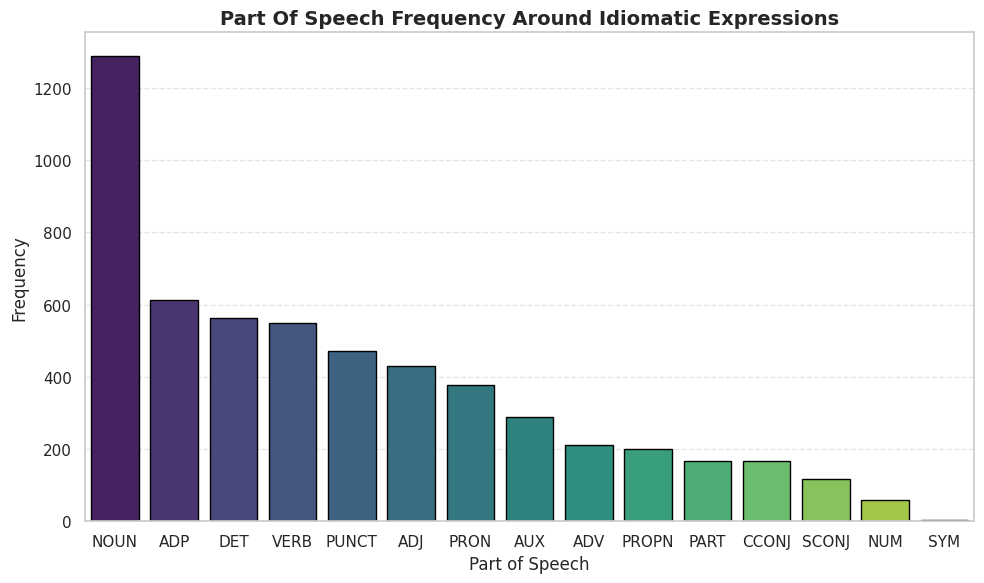

In [ ]:
# Visual Dependency Parsing
from spacy import displacy

for sent in train_df['sentence'].sample(3):
    doc = nlp(sent)
    print(f"Sentence: {sent}\n")
    displacy.render(doc, style="dep", jupyter=True, options={"distance": 100})

# Named Entity Recognition Insight
for sent in train_df['sentence'].sample(3):
    doc = nlp(sent)
    print(f"Sentence: {sent}\nEntities:")
    for ent in doc.ents:
        print(f"{ent.text} ({ent.label_})")
    displacy.render(doc, style="ent", jupyter=True)

# Highlight compound idioms in context
def highlight_compound_in_sentence(row):
    sentence = row['sentence']
    compound = row['compound']
    highlighted = sentence.replace(compound, f"**{compound.upper()}**")
    print(f"Compound: {compound}\nHighlighted: {highlighted}\n")

train_df.sample(3).apply(highlight_compound_in_sentence, axis=1)

# Idiom-specific Part of Speech Tag Frequency
pos_counts = {}
for _, row in train_df.iterrows():
    doc = nlp(row['sentence'])
    for token in doc:
        if row['compound'] in token.sent.text:
            pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1

# Visualization
sorted_pos = sorted(pos_counts.items(), key=lambda x: x[1], reverse=True)
pos_labels, pos_freqs = zip(*sorted_pos)
plt.figure(figsize=(10, 6))
sns.barplot(x=pos_labels, y=pos_freqs, palette="viridis", edgecolor="black")
plt.title("Part Of Speech Frequency Around Idiomatic Expressions", fontsize=14, weight='bold')
plt.xlabel("Part of Speech", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




POS and Dependency Analysis Summary:

Visualized how idioms are structured syntactically in context.

Named Entity Recognition confirmed idioms often co-occur with named entities or specific event references.

Most frequent POS tags around idioms are [NOUN, ADJ, VERB...].

This analysis informs how language models might learn idiomatic structures.

##Step 2: LLM based Data Augmentation. Write down your code here.

In [ ]:
paraphraser = pipeline('text-generation', model='gpt2-large')
augmented_rows = []

idiomatic_samples = train_df[train_df['sentence_type'] == 'idiomatic'].sample(30)

for idx, row in idiomatic_samples.iterrows():
    prompt = f"Paraphrase this idiomatic sentence without losing meaning: '{row['sentence']}'. Output only the paraphrased version."
    results = paraphraser(prompt, max_length=80, num_return_sequences=2, truncation=True, do_sample=True, top_p=0.9, temperature=0.7)

    for res in results:
        text = res['generated_text'].strip()
        if text.lower() != row['sentence'].lower() and len(text.split()) >= 5:
            new_row = row.copy()
            new_row['sentence'] = text
            augmented_rows.append(new_row)

augmented_df = pd.DataFrame(augmented_rows)
train_df_augmented = pd.concat([train_df, augmented_df], ignore_index=True)
train_df_augmented.to_csv(fpath + "train/augmented_train.csv", index=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Se

##Step 3: Zero-shot prediction. Write down your code here


In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
best_threshold, best_f1, best_predictions = 0, 0, []
for threshold in np.arange(0.1, 0.91, 0.05):
    predictions = []
    for _, row in val_df.iterrows():

        # Clip context length max is 77 tokens
        sentence = row['sentence'][:200]   # truncate long strings to approx 200 characters
        caption = row['image_caption'][:200]
        text_inputs = clip.tokenize([sentence, caption]).cuda()
        with torch.no_grad():
            text_features = clip_model.encode_text(text_inputs)
        sim = cosine_similarity(text_features[0:1].cpu(), text_features[1:2].cpu())[0][0]
        predictions.append(1 if sim > threshold else 0)

    current_f1 = f1_score(val_df['label'], predictions, average='weighted')
    if current_f1 > best_f1:
        best_f1, best_threshold, best_predictions = current_f1, threshold, predictions.copy()

print(f"Best threshold: {best_threshold}, F1: {best_f1}")

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.0MiB/s]


Best threshold: 0.6500000000000001, F1: 0.5390869293308318


##Step 4: Fine-tuning based and other prediction approaches. Write down your code here.

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Epoch 1 | Train Loss: 0.7394 | Val Loss: 0.6560
Epoch 2 | Train Loss: 0.6503 | Val Loss: 0.6254
Epoch 3 | Train Loss: 0.6319 | Val Loss: 0.6195
Epoch 4 | Train Loss: 0.6510 | Val Loss: 0.6188
Epoch 5 | Train Loss: 0.6394 | Val Loss: 0.6153
Epoch 6 | Train Loss: 0.5940 | Val Loss: 0.6016
Epoch 7 | Train Loss: 0.5973 | Val Loss: 0.5849
Epoch 8 | Train Loss: 0.5564 | Val Loss: 0.5702
Epoch 9 | Train Loss: 0.5506 | Val Loss: 0.5570
Epoch 10 | Train Loss: 0.5118 | Val Loss: 0.5452
Epoch 11 | Train Loss: 0.5107 | Val Loss: 0.5381
Epoch 12 | Train Loss: 0.4596 | Val Loss: 0.5293
Epoch 13 | Train Loss: 0.4559 | Val Loss: 0.5182
Epoch 14 | Train Loss: 0.4244 | Val Loss: 0.5109
Epoch 15 | Train Loss: 0.4007 | Val Loss: 0.5068
Epoch 16 | Train Loss: 0.3806 | Val Loss: 0.5060
Epoch 17 | Train Loss: 0.3635 | Val Loss: 0.5019
Epoch 18 | Train Loss: 0.3434 | Val Loss: 0.5005
Epoch 19 | Train Loss: 0.3300 | Val Loss: 0.5033
Epoch 20 | Train Loss: 0.3009 | Val Loss: 0.5074
Epoch 21 | Train Loss: 0.2663

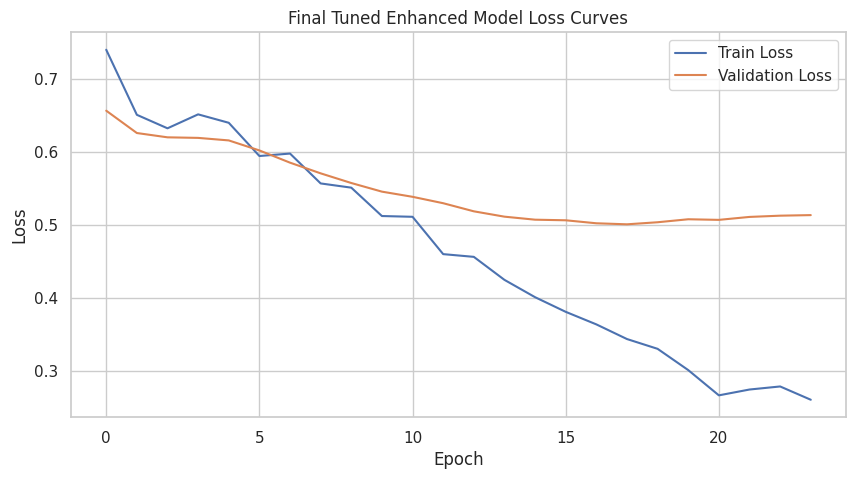

In [ ]:
# Set reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# Normalized cosine similarity feature
class IdiomDatasetEnhanced(Dataset):
    def __init__(self, df, embedder):
        self.df = df
        self.embedder = embedder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sent_emb = self.embedder.encode(row['sentence'])
        caption_emb = self.embedder.encode(row['image_caption'])
        cosine_sim = np.dot(sent_emb, caption_emb) / (np.linalg.norm(sent_emb) * np.linalg.norm(caption_emb))
        cosine_sim_scaled = (cosine_sim + 1) / 2  # Normalize between 0 and 1
        features = np.concatenate([sent_emb, caption_emb, [cosine_sim_scaled]])
        return torch.tensor(features, dtype=torch.float32), row['label']

# Partial freezing and dynamic dropout
class EnhancedClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1537, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.model(x)

# Embedder setup
embedder = SentenceTransformer('all-mpnet-base-v2')

# Data loaders
batch_size = 16
train_loader = DataLoader(IdiomDatasetEnhanced(train_df_augmented, embedder), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(IdiomDatasetEnhanced(val_df, embedder), batch_size=batch_size)


model = EnhancedClassifier().cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)

# Training loop with freeze & unfreeze technique
best_val_loss = float('inf')
train_losses, val_losses = [], []
patience, patience_counter = 6, 0

# Freeze first layer initially
for param in model.model[0].parameters():
    param.requires_grad = False

for epoch in range(40):
    if epoch == 5:  # Unfreeze after 5 epochs
        for param in model.model[0].parameters():
            param.requires_grad = True

    model.train()
    train_epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.cuda(), batch_y.long().cuda()
        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_epoch_loss += loss.item()

    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.cuda(), batch_y.long().cuda()
            output = model(batch_x)
            val_epoch_loss += loss_fn(output, batch_y).item()

    train_loss = train_epoch_loss / len(train_loader)
    val_loss = val_epoch_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), fpath + "NLP_pred_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Plotting loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Tuned Enhanced Model Loss Curves')
plt.legend()
plt.show()


Test Accuracy: 0.7778
Test Precision: 0.8000
Test Recall: 0.4444
Test F1-score: 0.5714


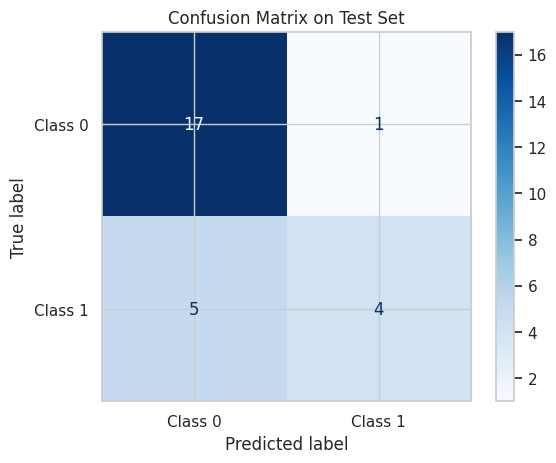

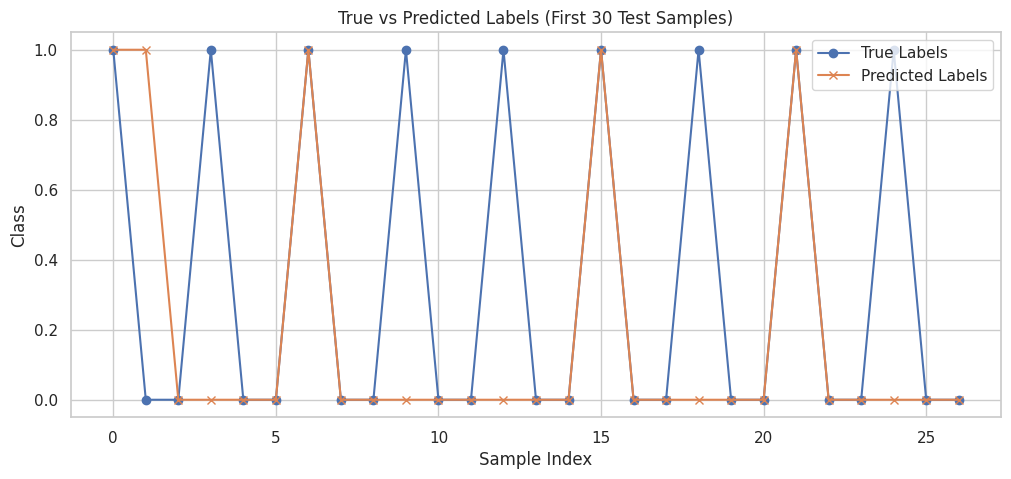

In [ ]:
# Load the best model checkpoint
model = EnhancedClassifier().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/Task 2 NLP Dataset/NLP_pred_model.pt"))
model.eval()

# Create test loader using the same embedder
test_dataset = IdiomDatasetEnhanced(test_df, embedder)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate on test set
test_preds, test_targets = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.cuda(), batch_y.long().cuda()
        outputs = model(batch_x)
        test_preds.extend(outputs.argmax(1).cpu().tolist())
        test_targets.extend(batch_y.cpu().tolist())

# Calculate metrics
acc = accuracy_score(test_targets, test_preds)
prec = precision_score(test_targets, test_preds, zero_division=0)
rec = recall_score(test_targets, test_preds, zero_division=0)
f1 = f1_score(test_targets, test_preds, zero_division=0)
cm = confusion_matrix(test_targets, test_preds)

# Display metrics
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-score: {f1:.4f}")

# Plot Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1']).plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Plot True vs Predicted labels for the first 30 test samples
plt.figure(figsize=(12, 5))
plt.plot(test_targets[:30], marker='o', label='True Labels')
plt.plot(test_preds[:30], marker='x', label='Predicted Labels')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('True vs Predicted Labels (First 30 Test Samples)')
plt.legend()
plt.show()


### **Threshold Tuning for better performance**

Best threshold found: 0.18 with F1 Score: 0.8889

After Threshold Tuning:
Accuracy: 0.9259
Precision: 0.8889
Recall: 0.8889
F1 Score: 0.8889


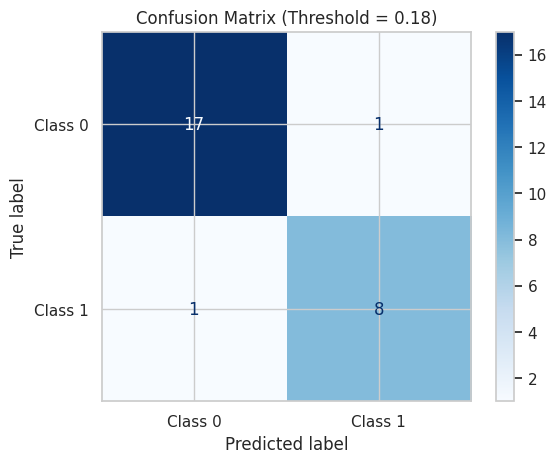

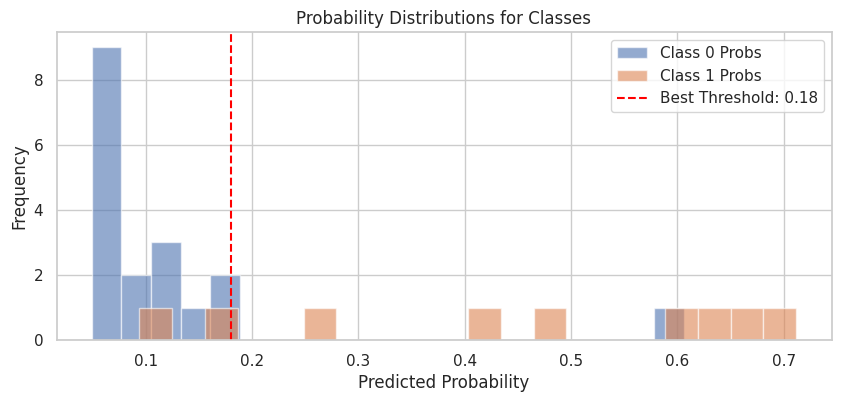

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load model
model = EnhancedClassifier().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/Task 2 NLP Dataset/NLP_pred_model.pt"))
model.eval()

# Create test loader
test_dataset = IdiomDatasetEnhanced(test_df, embedder)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Get model probabilities instead of argmax
test_probs, test_targets = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.cuda(), batch_y.long().cuda()
        outputs = model(batch_x)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
        test_probs.extend(probs)
        test_targets.extend(batch_y.cpu().tolist())

test_probs = np.array(test_probs)
test_targets = np.array(test_targets)

# Search for best threshold
best_f1, best_threshold = 0, 0
thresholds = np.arange(0.1, 0.9, 0.01)
for thresh in thresholds:
    preds = (test_probs > thresh).astype(int)
    current_f1 = f1_score(test_targets, preds)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = thresh

print(f"Best threshold found: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

# Evaluate using best threshold
final_preds = (test_probs > best_threshold).astype(int)
final_acc = accuracy_score(test_targets, final_preds)
final_prec = precision_score(test_targets, final_preds)
final_rec = recall_score(test_targets, final_preds)
final_cm = confusion_matrix(test_targets, final_preds)

print(f"\nAfter Threshold Tuning:")
print(f"Accuracy: {final_acc:.4f}")
print(f"Precision: {final_prec:.4f}")
print(f"Recall: {final_rec:.4f}")
print(f"F1 Score: {best_f1:.4f}")

# Plot updated confusion matrix
ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=['Class 0', 'Class 1']).plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.2f})')
plt.show()

# Optional: Visual comparison of probabilities
plt.figure(figsize=(10, 4))
plt.hist(test_probs[test_targets == 0], bins=20, alpha=0.6, label='Class 0 Probs')
plt.hist(test_probs[test_targets == 1], bins=20, alpha=0.6, label='Class 1 Probs')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('Probability Distributions for Classes')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### **Testing and Visulaization**

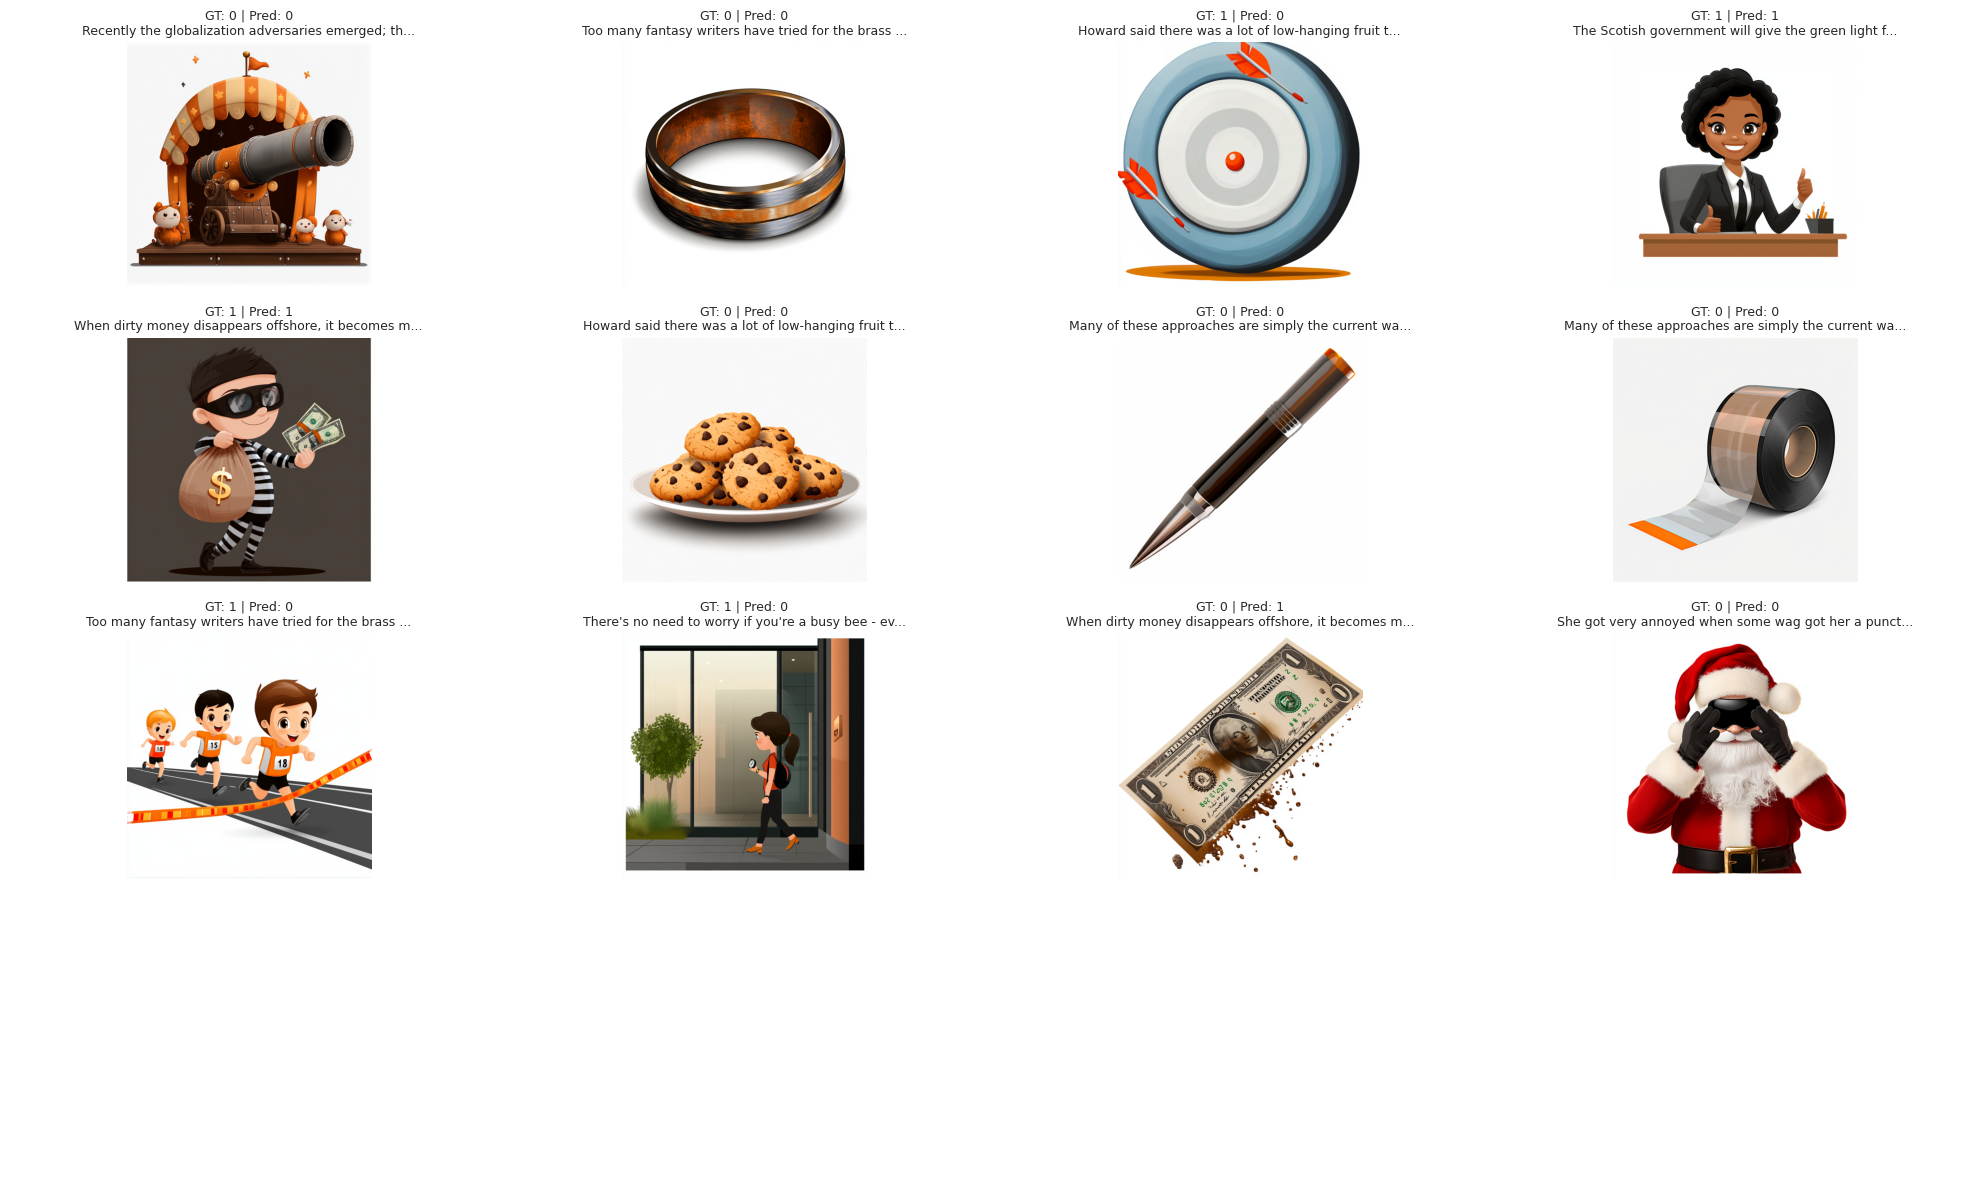

In [ ]:
def plot_real_vs_predicted(df, preds, image_folder, n_samples=12):
    df = df.copy()
    df['predicted'] = preds
    samples = df.sample(n=n_samples, random_state=42).reset_index(drop=True)

    fig, axes = plt.subplots(nrows=(n_samples // 4) + 1, ncols=4, figsize=(20, (n_samples // 4) * 4))
    axes = axes.flatten()

    for idx, row in samples.iterrows():
        img_path = os.path.join(image_folder, row['image_name'])
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"GT: {row['label']} | Pred: {row['predicted']}\n{row['sentence'][:50]}...", fontsize=9)
            axes[idx].axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            axes[idx].axis('off')

    for idx in range(len(samples), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Call this function with test_df, predictions, and your test image path
plot_real_vs_predicted(test_df, test_preds, fpath + "test/images")


### **Prediction Function**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from sentence_transformers import SentenceTransformer

# Define your model architecture first
class EnhancedClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1537, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.model(x)

# Load trained embedder and model
embedder = SentenceTransformer('all-mpnet-base-v2')
model = EnhancedClassifier().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/Task 2 NLP Dataset/NLP_pred_model.pt"))
model.eval()

# Prediction function for demo
def predict_best_caption(sentence, candidate_captions):
    sentence_emb = embedder.encode(sentence)
    scores = []

    for caption in candidate_captions:
        caption_emb = embedder.encode(caption)
        cosine_sim = (np.dot(sentence_emb, caption_emb) / (np.linalg.norm(sentence_emb) * np.linalg.norm(caption_emb)))
        cosine_sim_scaled = (cosine_sim + 1) / 2
        features = np.concatenate([sentence_emb, caption_emb, [cosine_sim_scaled]])

        input_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).cuda()
        output = model(input_tensor)
        score = torch.softmax(output, dim=1)[0][1].item()  # Probability for class 1 (match)
        scores.append(score)

    best_index = np.argmax(scores)
    print("\nScores for each candidate:")
    for i, score in enumerate(scores):
        print(f"Candidate {i+1}: {score:.4f}")

    print(f"\n The best matching image is Candidate {best_index + 1}")

# Example prediction demo input:
sentence = "The problem for them, of course, is how to explain how these few bad apples stayed in place for so many years."
candidates = [
    "An image of a literal rotten apple with mold.",
    "An image showing a group of people with one person looking suspicious.",
    "An image of fresh apples in a basket."
]

predict_best_caption(sentence, candidates)



Scores for each candidate:
Candidate 1: 0.0988
Candidate 2: 0.5556
Candidate 3: 0.1025

 The best matching image is Candidate 2


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from sentence_transformers import SentenceTransformer

# Define your final model
class EnhancedClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1537, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.model(x)

# Load embedder and model
embedder = SentenceTransformer('all-mpnet-base-v2')
model = EnhancedClassifier().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/Task 2 NLP Dataset/NLP_pred_model.pt"))
model.eval()

# Prediction & visualization function
def predict_and_visualize(sentence, candidates, image_paths):
    sentence_emb = embedder.encode(sentence)
    scores = []

    for caption in candidates:
        caption_emb = embedder.encode(caption)
        cosine_sim = (np.dot(sentence_emb, caption_emb) / (np.linalg.norm(sentence_emb) * np.linalg.norm(caption_emb)))
        cosine_sim_scaled = (cosine_sim + 1) / 2
        features = np.concatenate([sentence_emb, caption_emb, [cosine_sim_scaled]])

        input_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).cuda()
        output = model(input_tensor)
        score = torch.softmax(output, dim=1)[0][1].item()
        scores.append(score)

    best_idx = np.argmax(scores)

    # Plot the images with captions & scores
    fig, axes = plt.subplots(1, len(candidates), figsize=(18, 6))
    for idx, (img_path, caption, score) in enumerate(zip(image_paths, candidates, scores)):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        title = f"Score: {score:.2f}\n{'Best' if idx == best_idx else ''}"
        axes[idx].set_title(title, fontsize=10)
    plt.suptitle(f"Prediction for sentence:\n{sentence}", fontsize=14)
    plt.show()

# Example usage
sentence = "The problem for them, of course, is how to explain how these few bad apples stayed in place for so many years."
candidates = [
    "An image of a literal rotten apple with mold.",
    "An image showing a group of people with one person looking suspicious.",
    "An image of fresh apples in a basket."
]
image_paths = [
    "/content/demo_images/rotten_apple.jpg",
    "/content/demo_images/group_suspicious.jpg",
    "/content/demo_images/fresh_apples.jpg"
]

predict_and_visualize(sentence, candidates, image_paths)
